# Importing neccessary libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from bs4 import BeautifulSoup
import requests
import ast
import glob

## Read 2 dataframes

In [2]:
#Read the data
animes_df = pd.read_csv('data/anime_data.csv')

In [3]:
animes_df.head(10)

,ID,Name,Type,Episodes,Aired,Members,Scores
0,52991,Sousou no Frieren,TV,28,Sep 2023 - Mar 2024,"1,089,617 members",9.30
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,Apr 2009 - Jul 2010,"3,507,677 members",9.10
2,9253,Steins;Gate,TV,24,Apr 2011 - Sep 2011,"2,686,894 members",9.07
3,38524,Shingeki no Kyojin Season 3 Part 2,TV,10,Apr 2019 - Jul 2019,"2,431,574 members",9.05
4,60022,One Piece Fan Letter,TV Special,1,Oct 2024 - Oct 2024,"104,168 members",9.05
5,28977,Gintama°,TV,51,Apr 2015 - Mar 2016,"663,359 members",9.05
6,39486,Gintama: The Final,Movie,1,Jan 2021 - Jan 2021,"167,765 members",9.04
7,11061,Hunter x Hunter (2011),TV,148,Oct 2011 - Sep 2014,"3,006,879 members",9.03
8,9969,Gintama',TV,51,Apr 2011 - Mar 2012,"586,616 members",9.02
9,15417,Gintama': Enchousen,TV,13,Oct 2012 - Mar 2013,"342,717 members",9.02


# 1. Exploring data

## How many rows and how many columns?

In [4]:
print(f"The anime data has {animes_df.shape[0]} rows and {animes_df.shape[1]} columns.")

The anime data has 7150 rows and 7 columns.


## What is the current data type of each column? Are there columns having inappropriate data types?

In [5]:
animes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7150 entries, 0 to 7149
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7150 non-null   int64  
 1   Name      7150 non-null   object 
 2   Type      7150 non-null   object 
 3   Episodes  7150 non-null   object 
 4   Aired     7150 non-null   object 
 5   Members   7150 non-null   object 
 6   Scores    7150 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 391.1+ KB


We should preprocess the column Members so it has an int data type.

In [6]:
animes_df['Members'] = animes_df['Members'].str.replace(' members', '', regex=False)
animes_df['Members'] = animes_df['Members'].str.replace(',', '', regex=False)
animes_df['Members'] = animes_df['Members'].astype('int64')

In [7]:
animes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7150 entries, 0 to 7149
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7150 non-null   int64  
 1   Name      7150 non-null   object 
 2   Type      7150 non-null   object 
 3   Episodes  7150 non-null   object 
 4   Aired     7150 non-null   object 
 5   Members   7150 non-null   int64  
 6   Scores    7150 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 391.1+ KB


## With each numerical column, how are values distributed in movies dataframe?

In [8]:
num_col_info_df = animes_df.select_dtypes(exclude='object')
def missing_ratio(s):
    return (s.isna().mean() * 100).round(1)


num_col_info_df = num_col_info_df.agg([missing_ratio, "min", "max"])
num_col_info_df

,ID,Members,Scores
missing_ratio,0.0,0.0,0.0
min,1.0,219.0,6.5
max,61393.0,4143777.0,9.3


# 2. Data Preprocessing and EDA

I plan to label each anime based on their score, from my personal experience, animes that are rated from 8.5 and above 9 can be considered a "Masterpiece", from 7.8 to 8.5 is a "Good watch", from 7.2 to 7.8 is a 'Watchable" anime and from 6.5 to 7.2 is "Terrible" anime.

In [9]:
conditions = [animes_df['Scores'] >= 8.1,
              (animes_df['Scores'] >= 7.6) & (animes_df['Scores'] < 8.1),
              (animes_df['Scores'] >= 7.2) & (animes_df['Scores'] < 7.6),
              (animes_df['Scores'] >= 6.5) & (animes_df['Scores']) < 7.2]
labels = ['Top-tier', 'Worthwhile', 'Watchable', 'Terrible']

animes_df["Label"] = np.select(conditions, labels, default='Unrated')

In [10]:
animes_df.head(10)

,ID,Name,Type,Episodes,Aired,Members,Scores,Label
0,52991,Sousou no Frieren,TV,28,Sep 2023 - Mar 2024,1089617,9.30,Top-tier
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,Apr 2009 - Jul 2010,3507677,9.10,Top-tier
2,9253,Steins;Gate,TV,24,Apr 2011 - Sep 2011,2686894,9.07,Top-tier
3,38524,Shingeki no Kyojin Season 3 Part 2,TV,10,Apr 2019 - Jul 2019,2431574,9.05,Top-tier
4,60022,One Piece Fan Letter,TV Special,1,Oct 2024 - Oct 2024,104168,9.05,Top-tier
5,28977,Gintama°,TV,51,Apr 2015 - Mar 2016,663359,9.05,Top-tier
6,39486,Gintama: The Final,Movie,1,Jan 2021 - Jan 2021,167765,9.04,Top-tier
7,11061,Hunter x Hunter (2011),TV,148,Oct 2011 - Sep 2014,3006879,9.03,Top-tier
8,9969,Gintama',TV,51,Apr 2011 - Mar 2012,586616,9.02,Top-tier
9,15417,Gintama': Enchousen,TV,13,Oct 2012 - Mar 2013,342717,9.02,Top-tier


Let's find out if the distribution is considerably even between labels

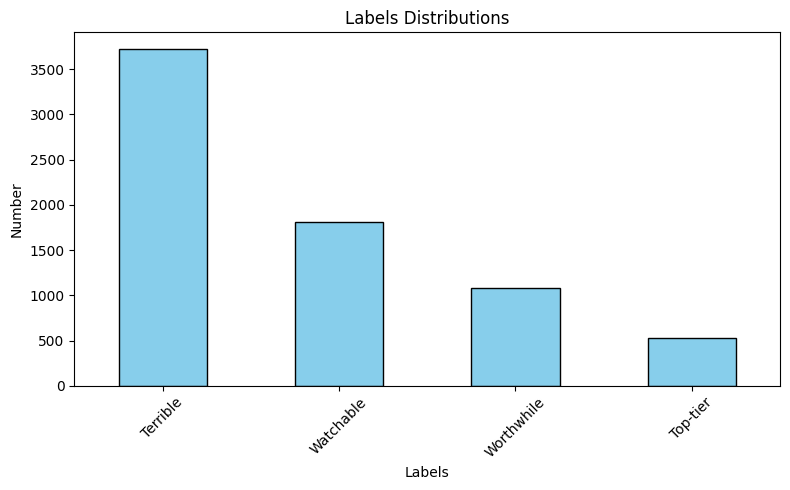

In [11]:
labels_count = animes_df['Label'].value_counts()

plt.figure(figsize=(8,5))

labels_count.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Labels Distributions')
plt.xlabel('Labels')
plt.ylabel('Number')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
type_count = animes_df['Type'].value_counts()
type_count

Type
TV            3312
Movie         1274
ONA            828
OVA            798
Special        673
TV Special     265
Name: count, dtype: int64

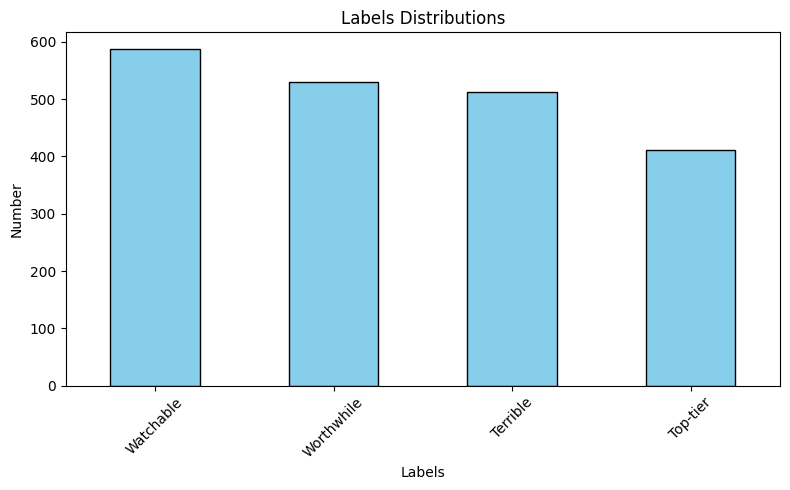

In [13]:
anime_TV_Movie_df = animes_df[(animes_df['Type'] == 'TV') | (animes_df['Type'] == 'Movie')]
anime_TV_Movie_df = animes_df[animes_df['Members'] >= 100000]
labels_count = anime_TV_Movie_df['Label'].value_counts()

plt.figure(figsize=(8,5))

labels_count.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Labels Distributions')
plt.xlabel('Labels')
plt.ylabel('Number')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now that we get all of the anime we want, it's time to get more information such as Genres and Sypnosis.

In [ ]:
anime_ids = anime_TV_Movie_df['ID'].tolist()

url = 'https://myanimelist.net/anime/'

# for id in anime_ids:

additional_info = {}
additional_info['ID'] = []
additional_info['Sypnosis'] = []
additional_info['Genres'] = []
for i in range(0,len(anime_ids)):
    response = requests.get(url + str(anime_ids[i]))
    if response.status_code == 200:
        # response = requests.get(url + str(52991))
        additional_info['ID'].append(anime_ids[i])
        soup = BeautifulSoup(response.text, 'html.parser')
        sypnosis = soup.find('p', attrs={'itemprop':'description'}).text
        additional_info['Sypnosis'].append(sypnosis)

        raw_genres_text = soup.find_all('span', attrs={'itemprop':'genre'})
        genres = [tag.text.strip() for tag in raw_genres_text]
        additional_info['Genres'].append(genres)
    else: print(f"Failed to retrieve data {response.status_code}")  

df = pd.DataFrame.from_dict(additional_info)

df.to_csv("data/preprocessed_anime_data", index=False)

In [30]:
len(anime_ids)

2041

In [64]:
import glob
csv_files = glob.glob('data/additional_data*.csv')
additional_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

In [66]:
merged_df = pd.merge(anime_TV_Movie_df, additional_df, on='ID')

In [74]:
merged_df['Genres'] = merged_df['Genres'].apply(lambda x: ', '.join(ast.literal_eval(x)) if isinstance(x, str) else x)

In [76]:
merged_df.head(10)
merged_df.to_csv('data/preprocessed_anime_data.csv', index=False)

## 3. EDA

### 1. Top 10 movies with highest ratings

In [75]:
top_10_movies = movies_data.nlargest(10, 'vote_average')

print(top_10_movies[["title", "genres"]])

                                            title                  genres
movieId                                                                  
189                                      Reckless  Fantasy, Comedy, Drama
722      The Haunted World of Edward D. Wood, Jr.             Documentary
756        Carmen Miranda: Bananas Is My Business             Documentary
1870                        Dancer, Texas Pop. 81   Comedy, Drama, Family
26655      Common Threads: Stories from the Quilt    History, Documentary
55757                     Chilly Scenes of Winter  Comedy, Drama, Romance
160590                        Survive and Advance                        
93040                               The Civil War             Documentary
8954                        Lightning in a Bottle                        
98803                        Little Miss Broadway    Drama, Family, Music


### 2. Top 10 movies with highest revenue

In [76]:
top_10_revenues = movies_data.nlargest(10, 'revenue')

print(top_10_revenues[["title", "revenue"]])

                                                title       revenue
movieId                                                            
72998                                          Avatar  2.787965e+09
122886                   Star Wars: The Force Awakens  2.068224e+09
1721                                          Titanic  1.845034e+09
89745                                    The Avengers  1.519558e+09
117529                                 Jurassic World  1.513529e+09
130634                                      Furious 7  1.506249e+09
122892                        Avengers: Age of Ultron  1.405404e+09
88125    Harry Potter and the Deathly Hallows: Part 2  1.342000e+09
106696                                         Frozen  1.274219e+09
102125                                     Iron Man 3  1.215440e+09


### 3. Which month has the highes revenue?

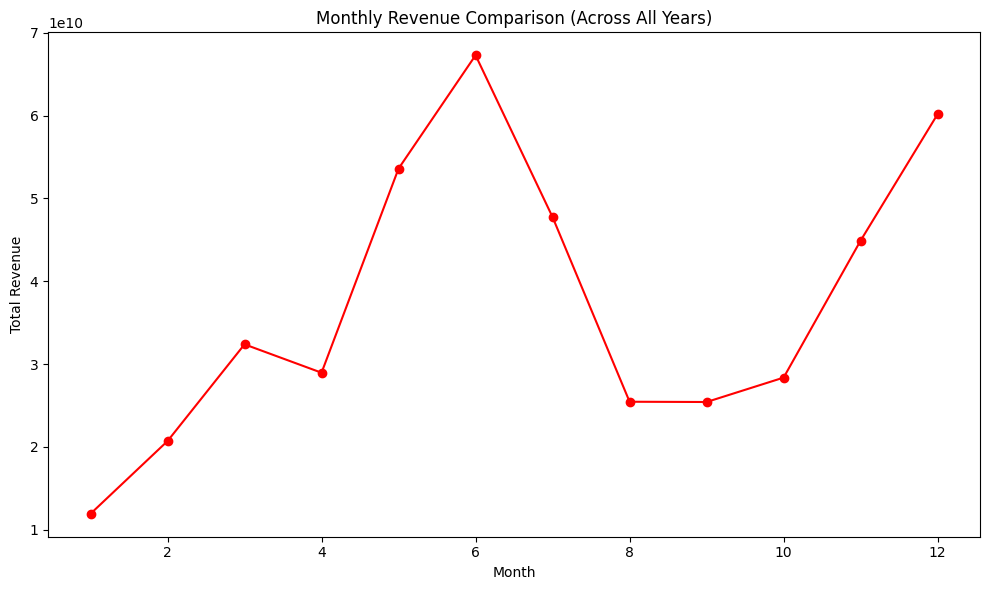

In [77]:
movies_data['month'] = movies_data['release_date'].dt.month

revenue_by_month = movies_data.groupby('month')['revenue'].sum()

plt.figure(figsize=(10, 6))
revenue_by_month.plot(kind='line', marker='o', color='r')

plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.title('Monthly Revenue Comparison (Across All Years)')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

We can see that movies from summer and winter gain the most revenue.

### 4. Compare every genre by revenue.

In [79]:
genre_revenue_df = movies_data[["genres", "revenue"]]

genre_revenue_df
genre_revenue_df['genres'] = genre_revenue_df['genres'].str.split(', ')
df_exploded = genre_revenue_df.explode('genres').reset_index()

print(df_exploded)

      movieId           genres      revenue
0           1        Animation  373554033.0
1           1           Comedy  373554033.0
2           1           Family  373554033.0
3           2        Adventure  262797249.0
4           2          Fantasy  262797249.0
...       ...              ...          ...
22486    5672        Animation   28023563.0
22487    5672  Science Fiction   28023563.0
22488    5672           Family   28023563.0
22489  114342           Comedy    1359497.0
22490  114342            Drama    1359497.0

[22491 rows x 3 columns]


<ipython-input-79-82142c76ae69>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_revenue_df['genres'] = genre_revenue_df['genres'].str.split(', ')


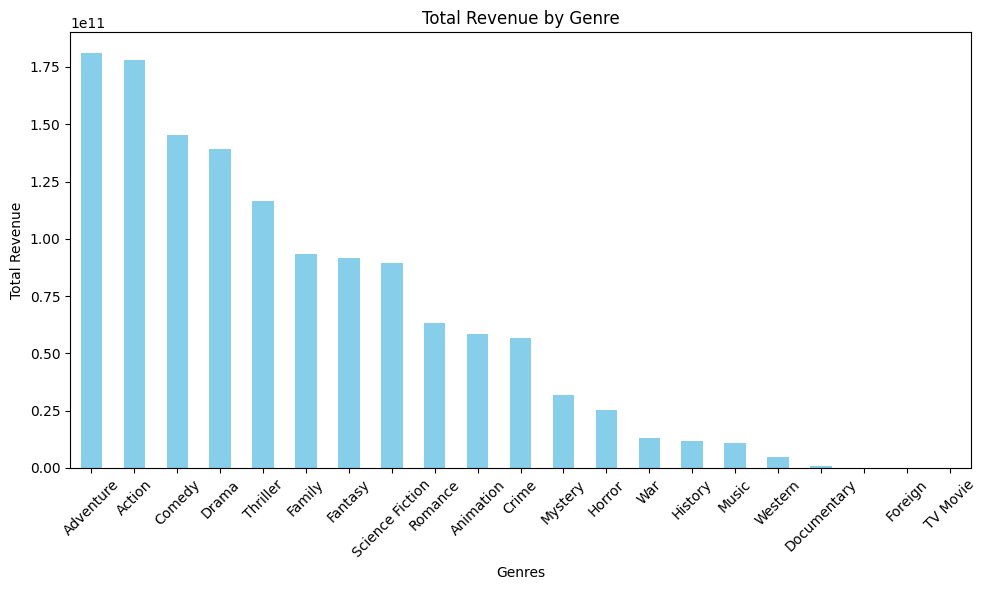

In [80]:
revenue_by_genre = df_exploded.groupby('genres')['revenue'].sum()

plt.figure(figsize=(10, 6))
revenue_by_genre.sort_values(ascending=False).plot(kind='bar', color='skyblue')

plt.xlabel('Genres')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Genre')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Adventure and action genres genrate the most income, comedy and drama are in third and fourth.